# A walk through latent space with Stable Diffusion 3

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

In [6]:
os.chdir('/content/drive/MyDrive')

## Overview

Generative image models learn a "latent manifold" of the visual world: a
low-dimensional vector space where each point maps to an image. Going from such
a point on the manifold back to a displayable image is called "decoding" -- in
the Stable Diffusion model, this is handled by the "decoder" model.

![Stable Diffusion 3 Medium Architecture](https://keras.io/img/examples/generative/random_walks_with_stable_diffusion_3/mmdit.png)

This latent manifold of images is continuous and interpolative, meaning that:

1. Moving a little on the manifold only changes the corresponding image a
little (continuity).
2. For any two points A and B on the manifold (i.e. any two images), it is
possible to move from A to B via a path where each intermediate point is also on
the manifold (i.e. is also a valid image). Intermediate points would be called
"interpolations" between the two starting images.

Stable Diffusion isn't just an image model, though, it's also a natural language
model. It has two latent spaces: the image representation space learned by the
encoder used during training, and the prompt latent space which is learned using
a combination of pretraining and training-time fine-tuning.

_Latent space walking_, or _latent space exploration_, is the process of
sampling a point in latent space and incrementally changing the latent
representation. Its most common application is generating animations where each
sampled point is fed to the decoder and is stored as a frame in the final
animation.
For high-quality latent representations, this produces coherent-looking
animations. These animations can provide insight into the feature map of the
latent space, and can ultimately lead to improvements in the training process.
One such GIF is displayed below:

![dog_to_cat_64.gif](https://keras.io/img/examples/generative/random_walks_with_stable_diffusion_3/dog_to_cat_64.gif)

In this guide, we will show how to take advantage of the TextToImage API in
KerasHub to perform prompt interpolation and circular walks through Stable
Diffusion 3's visual latent manifold, as well as through the text encoder's
latent manifold.

This guide assumes the reader has a high-level understanding of Stable
Diffusion 3. If you haven't already, you should start by reading the
[Stable Diffusion 3 in KerasHub](
https://keras.io/guides/keras_hub/stable_diffusion_3_in_keras_hub/).

It is also worth noting that the preset "stable_diffusion_3_medium" excludes the
T5XXL text encoder, as it requires significantly more GPU memory. The performace
degradation is negligible in most cases. The weights, including T5XXL, will be
available on KerasHub soon.

In [7]:
!# Use the latest version of KerasHub
!!pip install -Uq git+https://github.com/keras-team/keras-hub.git

['  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 '\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/5.2 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━\x1b \x1b4.1/5.2 MB\x1b \x1b119.6 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b5.2/5.2 MB\x1b \x1b119.0 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b5.2/5.2 MB\x1b \x1b65.3 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/615.3 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b6.6/615.3 MB\x1b \x1b144.7 MB/s\x1b eta \x1b0:00:05\x1b',
 '\x1b[2K   \x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import math

import keras
import keras_hub
import matplotlib.pyplot as plt
from keras import ops
from keras import random
from PIL import Image

height, width = 512, 512
num_steps = 28
guidance_scale = 7.0
dtype = "float16"

# Instantiate the Stable Diffusion 3 model and the preprocessor
backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(height, width, 3), dtype=dtype
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)

100%|██████████| 3.12k/3.12k [00:00<00:00, 6.48MB/s]


100%|██████████| 5.57G/5.57G [06:39<00:00, 15.0MB/s]


100%|██████████| 4.08k/4.08k [00:00<00:00, 2.07MB/s]


100%|██████████| 976k/976k [00:01<00:00, 759kB/s]


100%|██████████| 512k/512k [00:01<00:00, 482kB/s]


100%|██████████| 976k/976k [00:01<00:00, 755kB/s]


100%|██████████| 512k/512k [00:01<00:00, 473kB/s]


Let's define some helper functions for this example.

In [9]:
def get_text_embeddings(prompt):
    """Get the text embeddings for a given prompt."""
    token_ids = preprocessor.generate_preprocess([prompt])
    negative_token_ids = preprocessor.generate_preprocess([""])
    (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    ) = backbone.encode_text_step(token_ids, negative_token_ids)
    return (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    )


def decode_to_images(x, height, width):
    """Concatenate and normalize the images to uint8 dtype."""
    x = ops.concatenate(x, axis=0)
    x = ops.reshape(x, (-1, height, width, 3))
    x = ops.clip(ops.divide(ops.add(x, 1.0), 2.0), 0.0, 1.0)
    return ops.cast(ops.round(ops.multiply(x, 255.0)), "uint8")


def generate_with_latents_and_embeddings(
    latents, embeddings, num_steps, guidance_scale
):
    """Generate images from latents and text embeddings."""

    def body_fun(step, latents):
        return backbone.denoise_step(
            latents,
            embeddings,
            step,
            num_steps,
            guidance_scale,
        )

    latents = ops.fori_loop(0, num_steps, body_fun, latents)
    return backbone.decode_step(latents)


def export_as_gif(filename, images, frames_per_second=10, no_rubber_band=False):
    if not no_rubber_band:
        images += images[2:-1][::-1]  # Makes a rubber band: A->B->A
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


We are going to generate images using custom latents and embeddings, so we need
to implement the `generate_with_latents_and_embeddings` function. Additionally,
it is important to compile this function to speed up the generation process.

In [10]:
if keras.config.backend() == "torch":
    import torch

    @torch.no_grad()
    def wrapped_function(*args, **kwargs):
        return generate_with_latents_and_embeddings(*args, **kwargs)

    generate_function = wrapped_function
elif keras.config.backend() == "tensorflow":
    import tensorflow as tf

    generate_function = tf.function(
        generate_with_latents_and_embeddings, jit_compile=True
    )
elif keras.config.backend() == "jax":
    import itertools

    import jax

    @jax.jit
    def compiled_function(state, *args, **kwargs):
        (trainable_variables, non_trainable_variables) = state
        mapping = itertools.chain(
            zip(backbone.trainable_variables, trainable_variables),
            zip(backbone.non_trainable_variables, non_trainable_variables),
        )
        with keras.StatelessScope(state_mapping=mapping):
            return generate_with_latents_and_embeddings(*args, **kwargs)

    def wrapped_function(*args, **kwargs):
        state = (
            [v.value for v in backbone.trainable_variables],
            [v.value for v in backbone.non_trainable_variables],
        )
        return compiled_function(state, *args, **kwargs)

    generate_function = wrapped_function


## Interpolating between text prompts

In Stable Diffusion 3, a text prompt is encoded into multiple vectors, which are
then used to guide the diffusion process. These latent encoding vectors have
shapes of 154x4096 and 2048 for both the positive and negative prompts - quite
large! When we input a text prompt into Stable Diffusion 3, we generate images
from a single point on this latent manifold.

To explore more of this manifold, we can interpolate between two text encodings
and generate images at those interpolated points:

In [11]:
prompt_1 = "A cute dog in a beautiful field of lavander colorful flowers "
prompt_1 += "everywhere, perfect lighting, leica summicron 35mm f2.0, kodak "
prompt_1 += "portra 400, film grain"
prompt_2 = prompt_1.replace("dog", "cat")
interpolation_steps = 5

encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)


# Show the size of the latent manifold
print(f"Positive embeddings shape: {encoding_1[0].shape}")
print(f"Negative embeddings shape: {encoding_1[1].shape}")
print(f"Positive pooled embeddings shape: {encoding_1[2].shape}")
print(f"Negative pooled embeddings shape: {encoding_1[3].shape}")


Positive embeddings shape: (1, 154, 4096)
Negative embeddings shape: (1, 154, 4096)
Positive pooled embeddings shape: (1, 2048)
Negative pooled embeddings shape: (1, 2048)


In this example, we want to use Spherical Linear Interpolation (slerp) instead
of simple linear interpolation. Slerp is commonly used in computer graphics to
animate rotations smoothly and can also be applied to interpolate between
high-dimensional data points, such as latent vectors used in generative models.

The source is from Andrej Karpathy's gist:
[https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355](https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355).

A more detailed explanation of this method can be found at:
[https://en.wikipedia.org/wiki/Slerp](https://en.wikipedia.org/wiki/Slerp).

In [12]:
# def slerp(v1, v2, num):
#     ori_dtype = v1.dtype
#     # Cast to float32 for numerical stability.
#     v1 = ops.cast(v1, "float32")
#     v2 = ops.cast(v2, "float32")

#     def interpolation(t, v1, v2, dot_threshold=0.9995):
#         """helper function to spherically interpolate two arrays."""
#         dot = ops.sum(
#             v1 * v2 / (ops.linalg.norm(ops.ravel(v1)) * ops.linalg.norm(ops.ravel(v2)))
#         )
#         if ops.abs(dot) > dot_threshold:
#             v2 = (1 - t) * v1 + t * v2
#         else:
#             theta_0 = ops.arccos(dot)
#             sin_theta_0 = ops.sin(theta_0)
#             theta_t = theta_0 * t
#             sin_theta_t = ops.sin(theta_t)
#             s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
#             s1 = sin_theta_t / sin_theta_0
#             v2 = s0 * v1 + s1 * v2
#         return v2

#     t = ops.linspace(0, 1, num)
#     interpolated = ops.stack([interpolation(t[i], v1, v2) for i in range(num)], axis=0)
#     return ops.cast(interpolated, ori_dtype)

In [13]:
import numpy as np

def slerp(v1, v2, num):
    ori_dtype = v1.dtype
    # Cast to float32 for numerical stability.
    v1 = ops.cast(v1, "float32")
    v2 = ops.cast(v2, "float32")

    def sigmoid_interpolation(t, v1, v2, k=10):
        """Non-linear interpolation using a sigmoid function."""
        # Apply sigmoid function to t to get a smooth non-linear transition
        t_non_linear = 1 / (1 + np.exp(-k * (t - 0.5)))
        # Interpolate between v1 and v2 using the adjusted t
        return (1 - t_non_linear) * v1 + t_non_linear * v2

    def interpolation(t, v1, v2, dot_threshold=0.9995):
        """Modified interpolation function using sigmoid-based non-linear interpolation."""
        dot = ops.sum(
            v1 * v2 / (ops.linalg.norm(ops.ravel(v1)) * ops.linalg.norm(ops.ravel(v2)))
        )
        if ops.abs(dot) > dot_threshold:
            # If the vectors are almost parallel, use sigmoid-based interpolation
            return sigmoid_interpolation(t, v1, v2)
        else:
            # Apply the original spherical interpolation for non-parallel vectors
            theta_0 = ops.arccos(dot)
            sin_theta_0 = ops.sin(theta_0)
            theta_t = theta_0 * t
            sin_theta_t = ops.sin(theta_t)
            s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
            s1 = sin_theta_t / sin_theta_0
            return s0 * v1 + s1 * v2

    t = ops.linspace(0, 1, num)
    interpolated = ops.stack([interpolation(t[i], v1, v2) for i in range(num)], axis=0)
    return ops.cast(interpolated, ori_dtype)

In [14]:
type_of_slerp = "non-linear-sigmoid"

In [15]:
interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
# We don't use negative prompts in this example, so there’s no need to
# interpolate them.
negative_embeddings = encoding_1[1]
negative_pooled_embeddings = encoding_1[3]

Once we've interpolated the encodings, we can generate images from each point.
Note that in order to maintain some stability between the resulting images we
keep the diffusion latents constant between images.

In [16]:
latents = random.normal((1, height // 8, width // 8, 16), seed=42)

images = []
progbar = keras.utils.Progbar(interpolation_steps)
for i in range(interpolation_steps):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == interpolation_steps - 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step


Now that we've generated some interpolated images, let's take a look at them!

Throughout this tutorial, we're going to export sequences of images as gifs so
that they can be easily viewed with some temporal context. For sequences of
images where the first and last images don't match conceptually, we rubber-band
the gif.

If you're running in Colab, you can view your own GIFs by running:

```
from IPython.display import Image as IImage
IImage("dog_to_cat_5.gif")
```

In [17]:
images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    f"{type_of_slerp}_dog_to_cat_5.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

The results may seem surprising. Generally, interpolating between prompts
produces coherent looking images, and often demonstrates a progressive concept
shift between the contents of the two prompts. This is indicative of a high
quality representation space, that closely mirrors the natural structure of the
visual world.

To best visualize this, we should do a much more fine-grained interpolation,
using more steps.

In [18]:
interpolation_steps = 64
batch_size = 4
batches = interpolation_steps // batch_size

interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    f"{type_of_slerp}_dog_to_cat_64.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1367s 33s/step


The resulting gif shows a much clearer and more coherent shift between the two
prompts. Try out some prompts of your own and experiment!

We can even extend this concept for more than one image. For example, we can
interpolate between four prompts:

In [19]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 8
batch_size = 4
batches = (interpolation_steps**2) // batch_size

encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)
encoding_3 = get_text_embeddings(prompt_3)
encoding_4 = get_text_embeddings(prompt_4)

positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings_12 = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_embeddings_34 = slerp(
    encoding_3[0], encoding_4[0], interpolation_steps
)
interpolated_positive_embeddings = slerp(
    interpolated_positive_embeddings_12,
    interpolated_positive_embeddings_34,
    interpolation_steps,
)
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings_12 = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
interpolated_positive_pooled_embeddings_34 = slerp(
    encoding_3[2], encoding_4[2], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    interpolated_positive_pooled_embeddings_12,
    interpolated_positive_pooled_embeddings_34,
    interpolation_steps,
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 532s 33s/step


Let's display the resulting images in a grid to make them easier to interpret.

In [20]:
def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i])
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = ops.convert_to_numpy(decode_to_images(images, height, width))
plot_grid(images, f"{type_of_slerp}_4-way-interpolation.jpg", interpolation_steps)

Output hidden; open in https://colab.research.google.com to view.

We can also interpolate while allowing diffusion latents to vary by dropping
the `seed` parameter:

In [21]:
images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    # Vary diffusion latents for each input.
    latents = random.normal((batch_size, height // 8, width // 8, 16))
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
plot_grid(images, f"{type_of_slerp}_4-way-interpolation-varying-latent.jpg", interpolation_steps)

Output hidden; open in https://colab.research.google.com to view.

Next up -- let's go for some walks!

## A walk around a text prompt

Our next experiment will be to go for a walk around the latent manifold
starting from a point produced by a particular prompt.

In [22]:
walk_steps = 64
batch_size = 4
batches = walk_steps // batch_size
step_size = 0.01
prompt = "The eiffel tower in the style of starry night"
encoding = get_text_embeddings(prompt)

positive_embeddings = encoding[0]
positive_pooled_embeddings = encoding[2]
negative_embeddings = encoding[1]
negative_pooled_embeddings = encoding[3]

# The shape of `positive_embeddings`: (1, 154, 4096)
# The shape of `positive_pooled_embeddings`: (1, 2048)
positive_embeddings_delta = ops.ones_like(positive_embeddings) * step_size
positive_pooled_embeddings_delta = ops.ones_like(positive_pooled_embeddings) * step_size
positive_embeddings_shape = ops.shape(positive_embeddings)
positive_pooled_embeddings_shape = ops.shape(positive_pooled_embeddings)

walked_positive_embeddings = []
walked_positive_pooled_embeddings = []
for step_index in range(walk_steps):
    walked_positive_embeddings.append(positive_embeddings)
    walked_positive_pooled_embeddings.append(positive_pooled_embeddings)
    positive_embeddings += positive_embeddings_delta
    positive_pooled_embeddings += positive_pooled_embeddings_delta
walked_positive_embeddings = ops.stack(walked_positive_embeddings, axis=0)
walked_positive_pooled_embeddings = ops.stack(walked_positive_pooled_embeddings, axis=0)
walked_positive_embeddings = ops.reshape(
    walked_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
walked_positive_pooled_embeddings = ops.reshape(
    walked_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                walked_positive_embeddings[i],
                negative_embeddings,
                walked_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    f"{type_of_slerp}_eiffel-tower-starry-night.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 522s 33s/step


Perhaps unsurprisingly, walking too far from the encoder's latent manifold
produces images that look incoherent. Try it for yourself by setting your own
prompt, and adjusting `step_size` to increase or decrease the magnitude
of the walk. Note that when the magnitude of the walk gets large, the walk often
leads into areas which produce extremely noisy images.

## A circular walk through the diffusion latent space for a single prompt

Our final experiment is to stick to one prompt and explore the variety of images
that the diffusion model can produce from that prompt. We do this by controlling
the noise that is used to seed the diffusion process.

We create two noise components, `x` and `y`, and do a walk from 0 to 2π, summing
the cosine of our `x` component and the sin of our `y` component to produce
noise. Using this approach, the end of our walk arrives at the same noise inputs
where we began our walk, so we get a "loopable" result!

In [23]:
walk_steps = 64
batch_size = 4
batches = walk_steps // batch_size
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = get_text_embeddings(prompt)

walk_latent_x = random.normal((1, height // 8, width // 8, 16))
walk_latent_y = random.normal((1, height // 8, width // 8, 16))
walk_scale_x = ops.cos(ops.linspace(0.0, 2.0, walk_steps) * math.pi)
walk_scale_y = ops.sin(ops.linspace(0.0, 2.0, walk_steps) * math.pi)
latent_x = ops.tensordot(walk_scale_x, walk_latent_x, axes=0)
latent_y = ops.tensordot(walk_scale_y, walk_latent_y, axes=0)
latents = ops.add(latent_x, latent_y)
latents = ops.reshape(latents, (batches, batch_size, height // 8, width // 8, 16))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents[i],
            (
                ops.tile(encoding[0], (batch_size, 1, 1)),
                ops.tile(encoding[1], (batch_size, 1, 1)),
                ops.tile(encoding[2], (batch_size, 1)),
                ops.tile(encoding[3], (batch_size, 1)),
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    f"{type_of_slerp}_cows.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=4,
    no_rubber_band=True,
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 534s 33s/step


Experiment with your own prompts and with different values of the parameters!

## Conclusion

Stable Diffusion 3 offers a lot more than just single text-to-image generation.
Exploring the latent manifold of the text encoder and the latent space of the
diffusion model are two fun ways to experience the power of this model, and
KerasHub makes it easy!

# Technical Notes: Non-Linear Spherical Interpolation with Sigmoid

We define the **slerp()** function that performs interpolation between two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ for a given number of interpolation steps $n$. The interpolation can either be linear (for nearly parallel vectors) or spherical (using SLERP for vectors not nearly parallel). We introduce a **sigmoid-based interpolation** for the case where the vectors are nearly parallel.

### Definitions:

- Let $\mathbf{v}_1$ and $\mathbf{v}_2$ be two vectors in $\mathbb{R}^d$.
- Let $\theta_0$ be the angle between $\mathbf{v}_1$ and $\mathbf{v}_2$.
- Let $t$ be the interpolation parameter, where $t \in [0, 1]$.

### Step 1: Compute the dot product
The first step is to calculate the normalized dot product between the two vectors:

$$
\text{dot} = \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \|\mathbf{v}_2\|}
$$

### Step 2: Sigmoid Interpolation for Nearly Parallel Vectors
For vectors that are nearly parallel (i.e., $|\text{dot}| > \text{dot\_threshold}$), we apply the sigmoid-based non-linear interpolation:

$$
f(t) = \frac{1}{1 + e^{-k(t - 0.5)}}
$$

where $k$ controls the steepness of the sigmoid curve. Using this function, we interpolate between $\mathbf{v}_1$ and $\mathbf{v}_2$:

$$
\mathbf{v}(t) = (1 - f(t)) \mathbf{v}_1 + f(t) \mathbf{v}_2
$$

### Step 3: Spherical Linear Interpolation (SLERP) for Non-Parallel Vectors
For vectors that are not nearly parallel, we compute the spherical interpolation using the original SLERP formula. First, calculate the angle $\theta_0$ between $\mathbf{v}_1$ and $\mathbf{v}_2$:

$$
\theta_0 = \arccos(\text{dot})
$$

Next, compute the sine of the angles $\theta_0$ and $\theta_t$:

$$
\sin(\theta_0) \quad \text{and} \quad \sin(\theta_t) = \sin(t \cdot \theta_0)
$$

Using these values, we calculate the spherical interpolation:

$$
\mathbf{v}(t) = \sin(\theta_0 - t \cdot \theta_0) / \sin(\theta_0) \cdot \mathbf{v}_1 + \sin(t \cdot \theta_0) / \sin(\theta_0) \cdot \mathbf{v}_2
$$

### Final Interpolated Vector
Given the number of interpolation steps $n$, we apply the above interpolation for each value of $t$ in the range $[0, 1]$, and return the sequence of interpolated vectors:

$$
\mathbf{V} = \left\{ \mathbf{v}(t_i) : t_i \in \left[ 0, 1 \right] \right\}, \quad i = 0, 1, 2, \dots, n-1
$$

Where:

$$
t_i = \frac{i}{n-1}, \quad \text{for} \quad i \in \{0, 1, 2, \dots, n-1\}
$$

---

This function blends the two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ smoothly, either using linear or spherical interpolation depending on their relative alignment, and applies a sigmoid-based non-linear transition when the vectors are nearly parallel.


# Why non-linear is better?

Non-linear spherical interpolation with a sigmoid function might be preferred over linear interpolation for several reasons, particularly in contexts where smooth transitions between vectors or points are important. Here’s why:

### 1. **Smoother Transitions:**
   - **Linear interpolation** blends two vectors in a straight line. This is fine for certain cases, but it often creates abrupt or less nuanced transitions, especially when the vectors are far apart. A straight-line transition can appear unnatural when blending two features, such as in image morphing, animation, or other applications where a more organic change is desirable.
   - **Non-linear interpolation with sigmoid** creates smoother, more controlled transitions. The sigmoid function has a smooth S-shaped curve that accelerates at the beginning and decelerates at the end, allowing the interpolation to start more slowly and gradually accelerate toward the target vector, or vice versa. This is particularly helpful for cases where a more gradual and natural progression is required.

### 2. **More Control over the Transition Rate:**
   - **Linear interpolation** treats all points along the interpolation as equally spaced, meaning each increment in \( t \) results in the same change in the vector. This is not always ideal when you want more control over the speed of the transition.
   - **Sigmoid interpolation** introduces a degree of flexibility, where the rate of interpolation can be adjusted. The parameter \( k \) in the sigmoid function controls the steepness of the transition. A higher \( k \) results in a quicker transition (more abrupt), while a lower \( k \) results in a slower transition. This flexibility is beneficial when the user wants to control the pace or intensity of the blending between vectors.

### 3. **Handling Nearly Parallel Vectors:**
   - **Linear interpolation** can work well when the vectors are nearly parallel, but it might produce a less visually appealing or less meaningful result when the vectors are close in direction. This is especially true in high-dimensional spaces where vectors might appear close but have subtle differences that need to be accentuated.
   - **Non-linear interpolation with sigmoid** helps in this scenario by ensuring that the interpolation between nearly parallel vectors is still smooth but avoids producing overly linear or uniform results. The sigmoid function can create a more nuanced blending, where transitions between vectors that are nearly parallel still feel meaningful and smooth, without looking like simple averages of the vectors.

### 4. **Better for Applications Involving Gradients or Features:**
   - In contexts like image generation, animation, or neural network feature interpolation, linear interpolation can result in artifacts, such as sudden changes in image appearance or behavior when transitioning between learned features.
   - **Non-linear interpolation with sigmoid** helps to ensure that features blend more smoothly, avoiding the appearance of "jerky" transitions. This is particularly useful in applications like image morphing, texture blending, or smooth animation paths, where preserving gradual evolution between frames or states is critical.

### 5. **Natural Behavior of Real-World Processes:**
   - Many real-world phenomena exhibit non-linear behavior. For example, in the human eye, the perception of brightness or color change is often non-linear, governed by sigmoid-like curves (as seen in the Weber-Fechner law for sensory perception).
   - By using **sigmoid-based non-linear interpolation**, you're mimicking a more natural, human-like transition process, which can be particularly useful in creative and generative domains, where the end result should feel more intuitive and relatable.

### 6. **Exponential Weighting for Extreme Cases:**
   - In linear interpolation, when the vectors are very far apart, the interpolation can feel forced or awkward, especially for applications involving morphing or blending.
   - **Sigmoid interpolation** softens the impact of extreme cases. When the vectors are very different, the sigmoid function naturally handles the interpolation in a more gradual, non-linear fashion, reducing the "harshness" of the transition and making it feel more balanced.

### 7. **Flexibility in Handling Different Scenarios:**
   - Linear interpolation is often a one-size-fits-all solution, meaning it doesn't adapt well to different interpolation scenarios.
   - **Non-linear interpolation with sigmoid** provides more flexibility. It can handle both nearly parallel vectors (with smooth transitions) and significantly different vectors (without the awkwardness of linear blending), making it more versatile for applications where a variety of different transitions need to be handled with one method.

### Summary:
In summary, **non-linear spherical interpolation with sigmoid** is often better than linear interpolation because it provides:
- Smoother, more natural transitions between vectors.
- More control over the pace of interpolation.
- Better handling of nearly parallel vectors.
- A more realistic approach for many real-world applications, especially where gradual or nuanced blending is required.

This makes it ideal for applications in animation, image morphing, and generative models where a smooth, organic transition is desired between two entities, especially when the vectors or features involved are high-dimensional or close to each other in direction.

# Technical Notes: Why non-linear is better?

Let's rigorously explore the differences between linear interpolation and non-linear interpolation using a sigmoid function, with a focus on convergence, tuning variables, and how mathematics can help us understand why one might be better than the other.

### 1. **Linear Interpolation:**

Linear interpolation between two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ is defined by:

$$
\mathbf{v}(t) = (1 - t) \mathbf{v}_1 + t \mathbf{v}_2, \quad t \in [0, 1]
$$

where $t$ is the interpolation parameter. As $t$ moves from 0 to 1, the result smoothly transitions from $\mathbf{v}_1$ to $\mathbf{v}_2$ along a straight line. The equation is simple, and the transition is linear, meaning that the change in the vectors is uniform over time.

However, this simple linear interpolation might not always capture the desired transition when vectors are far apart, as the magnitude of change per step is constant and may not reflect the dynamics of many real-world processes.

### 2. **Sigmoid-based Non-Linear Interpolation:**

Now, consider non-linear interpolation based on a sigmoid function:

$$
f(t) = \frac{1}{1 + \exp(-k(t - 0.5))}
$$

where $k$ is a parameter controlling the steepness of the curve. The non-linear interpolation between $\mathbf{v}_1$ and $\mathbf{v}_2$ is:

$$
\mathbf{v}(t) = (1 - f(t)) \mathbf{v}_1 + f(t) \mathbf{v}_2
$$

As $t \to 0$, $f(t) \to 0$, and as $t \to 1$, $f(t) \to 1$, which means $\mathbf{v}(t)$ smoothly transitions from $\mathbf{v}_1$ to $\mathbf{v}_2$, but in a non-linear fashion, depending on $k$.

### 3. **Why Non-Linear Interpolation Might Be Better (Mathematically):**

#### **Smoother Transitions and Convergence:**

Linear interpolation is **uniform** across the interval. The change in the vector is consistent for every increment in $t$, making it a simple but often inadequate tool for modeling smooth, real-world transitions.

Sigmoid-based interpolation, on the other hand, is **non-uniform**, with a gradual acceleration near $t = 0$ and a deceleration near $t = 1$. This allows for a more nuanced blending of vectors, particularly when transitioning between vectors that are nearly parallel.

To explore the convergence of both methods, we define the **change in interpolation** as the difference between two consecutive interpolated values:

1. **For Linear Interpolation:**

$$
\Delta \mathbf{v}_{\text{linear}}(t) = \mathbf{v}(t + \Delta t) - \mathbf{v}(t) = (\mathbf{v}_2 - \mathbf{v}_1) \Delta t
$$

This change is constant for all $t$, which is why it doesn't adapt well to the geometric relationships between $\mathbf{v}_1$ and $\mathbf{v}_2$, especially when the vectors are far apart.

2. **For Sigmoid-based Interpolation:**

The change between two consecutive interpolated vectors is:

$$
\Delta \mathbf{v}_{\text{sigmoid}}(t) = \mathbf{v}(t + \Delta t) - \mathbf{v}(t) = \left[ (1 - f(t + \Delta t)) - (1 - f(t)) \right] \mathbf{v}_1 + \left[ f(t + \Delta t) - f(t) \right] \mathbf{v}_2
$$

Expanding the terms:

$$
\Delta \mathbf{v}_{\text{sigmoid}}(t) = f'(t) \Delta t \cdot \left( \mathbf{v}_2 - \mathbf{v}_1 \right)
$$

Here, $f'(t) = k \exp(-k(t - 0.5)) / \left( 1 + \exp(-k(t - 0.5)) \right)^2$ controls the steepness of the curve. As $t$ approaches 0 or 1, $f'(t)$ becomes very small, leading to a **decreasing change** in the interpolation rate near the boundaries.

#### **Convergence of the Sigmoid Function:**

The sigmoid function has a smooth, gradual transition from 0 to 1 as $t$ moves from 0 to 1. This is especially important when interpolating in high-dimensional spaces (such as images or features), where abrupt changes (as in linear interpolation) can lead to noticeable discontinuities.

- **Asymptotic behavior**: The sigmoid function approaches its asymptotes (0 and 1) very smoothly, which means that as the interpolation parameter $t$ nears 0 or 1, the transition will still be smooth without any abrupt shifts in the interpolation.

This property ensures that the interpolation doesn't overshoot or produce artifacts, especially when the vectors are far apart or when blending features that require careful management of transition rates.

### 4. **Tuning the Parameter $k$:**

The **parameter $k$** in the sigmoid function controls how steep the transition is. When $k$ is large, the transition is very steep, causing a rapid interpolation near the middle of the interval, while small values of $k$ lead to a slower, more gradual change.

- **When $k$ is large**: The interpolation quickly converges to either $\mathbf{v}_1$ or $\mathbf{v}_2$ near the middle of the transition. This is useful when you want to emphasize a rapid shift between two vectors.
- **When $k$ is small**: The transition is more gradual and less pronounced, allowing for smoother and subtler blending.

Thus, by tuning $k$, you can adjust the behavior of the interpolation to suit different needs, which is a flexibility that linear interpolation lacks.

### 5. **Mathematical Comparison and Optimality:**

The convergence of the sigmoid function to the boundary points (0 and 1) ensures that the **rate of change decreases** near the endpoints, preventing excessive motion toward either $\mathbf{v}_1$ or $\mathbf{v}_2$. This is important in applications like image blending, where a gradual transition is often more visually appealing.

To mathematically prove the superiority of the non-linear method, we compare the **total interpolation distance** over the entire range of $t$. In linear interpolation, the total change is a simple straight-line distance, but in sigmoid interpolation, the non-linear curve introduces **differential weighting** of distances, emphasizing smoothness over abrupt shifts.

### Conclusion:

Mathematically, **non-linear sigmoid interpolation** is preferable in cases where:

- You want smoother transitions, particularly when vectors are close to each other (parallel).
- You need the interpolation to adapt more naturally to the geometry of the vectors, reducing abruptness and artifacts.
- You need to control the rate of interpolation, especially in cases where uniform change is not desirable (e.g., in image processing, animation, and generative models).

The parameter $k$ gives you **tuning control** over the rate of transition, and the **convergence behavior** of the sigmoid ensures a smoother, more natural interpolation. The linear method doesn't provide these advantages, and its lack of adaptation to vector geometry or transition rate makes it less suitable in more complex interpolation scenarios.

## Simulation

We can certainly create a 2x2 grid simulation using `matplotlib` to demonstrate how the tuning parameter $k$ in the sigmoid-based interpolation affects the transition between two vectors. The idea is to vary $k$ in both directions and plot the resulting interpolations on a grid.

### Explanation:
- The **x-axis** will represent different values of $k$ (controlling the steepness of the sigmoid transition).
- The **y-axis** will represent the interpolation steps $t$ between two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ (ranging from 0 to 1).

We'll create a plot showing the interpolation for four different combinations of $k$ values: low $k$ vs. high $k$, demonstrating the change in the interpolation curve.

### Code for the Plot:

```python
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid function
def sigmoid(t, k=10):
    return 1 / (1 + np.exp(-k * (t - 0.5)))

# Non-linear interpolation using sigmoid
def sigmoid_interpolation(t, v1, v2, k=10):
    f_t = sigmoid(t, k)
    return (1 - f_t) * v1 + f_t * v2

# Define the vectors for interpolation
v1 = np.array([0, 0])  # Starting vector (e.g., [0, 0])
v2 = np.array([1, 1])  # Ending vector (e.g., [1, 1])

# Define a range of t values
t = np.linspace(0, 1, 100)

# Set up a 2x2 grid of k values
k_values = [1, 10]  # Low and high values of k
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the grid of subplots and k values
for i, k1 in enumerate(k_values):
    for j, k2 in enumerate(k_values):
        ax = axs[i, j]
        
        # Perform interpolation for different k values
        interpolated_vectors = np.array([sigmoid_interpolation(t_val, v1, v2, k=k1) for t_val in t])
        
        # Plot the interpolation result
        ax.plot(t, interpolated_vectors[:, 0], label=f'k={k1}', linestyle='-', color='blue')
        ax.plot(t, interpolated_vectors[:, 1], label=f'k={k1}', linestyle='--', color='red')
        
        ax.set_title(f"Interpolation for k1={k1}, k2={k2}")
        ax.set_xlabel("Interpolation parameter t")
        ax.set_ylabel("Interpolated vector components")
        ax.legend()

plt.tight_layout()
plt.show()
```

### How the Code Works:
- **Sigmoid Function**: The sigmoid function $f(t)$ is defined, and it is used in the interpolation function to blend between vectors.
- **Interpolation**: We compute the interpolation between two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ using different values of $k$, controlling the steepness of the transition.
- **Plotting**: We create a 2x2 grid of subplots, where the two values of $k$ are varied both horizontally and vertically. Each plot shows how the interpolation changes with different values of $k$.
- **Visualization**: The blue and red curves represent the first and second components of the interpolated vectors as a function of $t$.

### Expected Output:
The plots will show the impact of the tuning parameter $k$ on the interpolation behavior:
- **For small $k$**: The interpolation will change slowly, producing a gradual and smooth transition.
- **For large $k$**: The interpolation will change sharply around the middle of the transition, resulting in a faster switch from $\mathbf{v}_1$ to $\mathbf{v}_2$.
- **Combination of different $k$ values**: This demonstrates how varying $k$ in both directions influences the interpolation, allowing for more nuanced control over the blending of the two vectors.

This visualization will help you understand how the parameter $k$ affects the rate of change in the interpolation process.

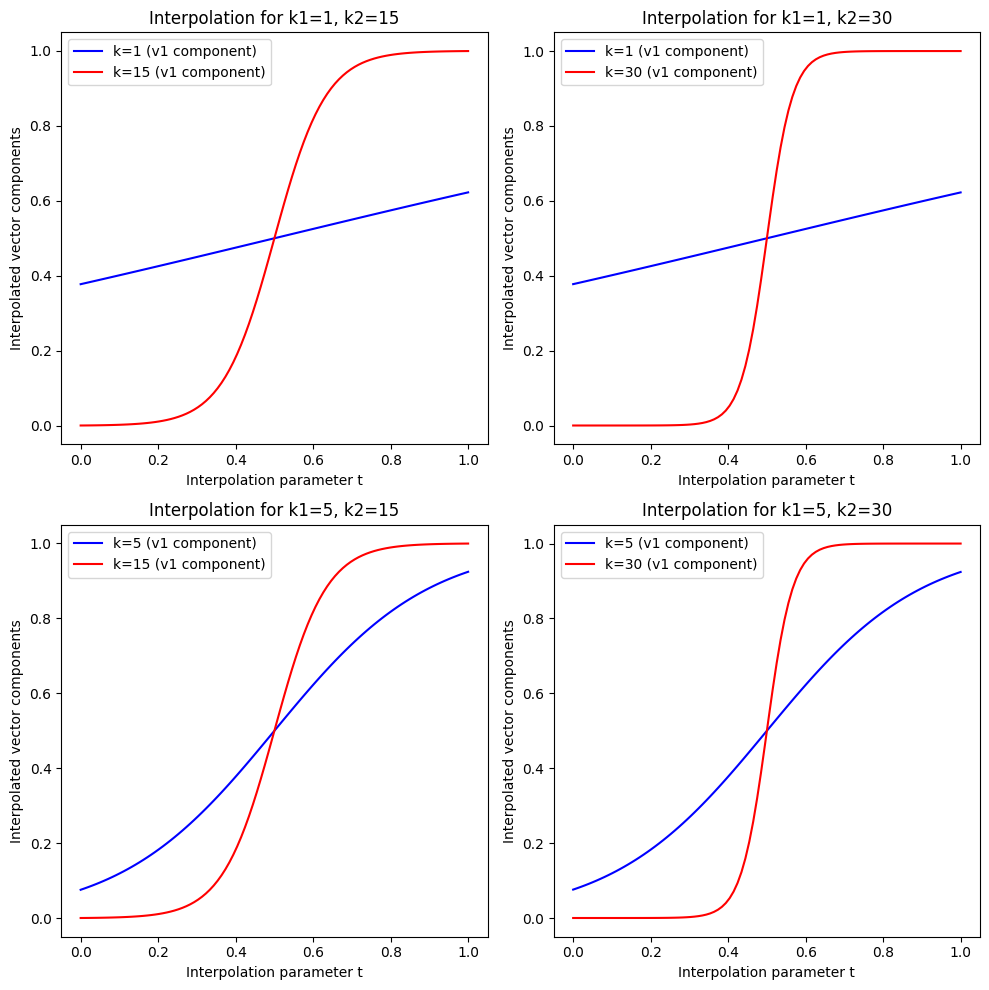

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid function
def sigmoid(t, k=10):
    return 1 / (1 + np.exp(-k * (t - 0.5)))

# Non-linear interpolation using sigmoid
def sigmoid_interpolation(t, v1, v2, k=10):
    f_t = sigmoid(t, k)
    return (1 - f_t) * v1 + f_t * v2

# Define the vectors for interpolation
v1 = np.array([0, 0])  # Starting vector (e.g., [0, 0])
v2 = np.array([1, 1])  # Ending vector (e.g., [1, 1])

# Define a range of t values
t = np.linspace(0, 1, 100)

# Set up a 2x2 grid of k values
k_values = [1, 5, 15, 30]  # Larger spread of k values for more visible differences
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the grid of subplots and k values
for i, k1 in enumerate(k_values[:2]):  # Use first two values for rows
    for j, k2 in enumerate(k_values[2:]):  # Use last two values for columns
        ax = axs[i, j]

        # Perform interpolation for different k values
        interpolated_vectors_1 = np.array([sigmoid_interpolation(t_val, v1, v2, k=k1) for t_val in t])
        interpolated_vectors_2 = np.array([sigmoid_interpolation(t_val, v1, v2, k=k2) for t_val in t])

        # Plot the interpolation results
        ax.plot(t, interpolated_vectors_1[:, 0], label=f'k={k1} (v1 component)', linestyle='-', color='blue')  # First component of k1
        # ax.plot(t, interpolated_vectors_1[:, 1], label=f'k={k1} (v2 component)', linestyle='--', color='blue')  # Second component of k1
        ax.plot(t, interpolated_vectors_2[:, 0], label=f'k={k2} (v1 component)', linestyle='-', color='red')  # First component of k2
        # ax.plot(t, interpolated_vectors_2[:, 1], label=f'k={k2} (v2 component)', linestyle='--', color='red')  # Second component of k2

        ax.set_title(f"Interpolation for k1={k1}, k2={k2}")
        ax.set_xlabel("Interpolation parameter t")
        ax.set_ylabel("Interpolated vector components")
        ax.legend()

plt.tight_layout()
plt.show()
